In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
def get_filled_txy(X, y, robot_pos=np.array([0,0]), max_range=80, unoccupied_points_per_meter=0.1, margin=0.05):
    """
    # converting raw lidar hits to BHM compatible hit-free format. 
    :param X: Nx2 numpy array of lidar positions (positions of 2D lidar hits or max distance)
    :param y: N numpy array (1 indicates reflected lidar beams (i.e. hits) and 0 indicates lidar beams that did not reflect back (i.e. no obstacle))
    :param robot_pos: 2 numpy array position of the robot 
    :param max_range: maximum lidar distance
    :param unoccupied_points_per_meter: required density of free points
    :param margin: UniformDistribution[margin, 1-margin] to sample free points. It should be a very small value. 
    :return Nx3 numpy array. The first two columns are positions of hits and sampled free (i.e. X). The last column is labels=y={0,1}={free,hits}
    """

    distances = np.sqrt(np.sum( (X - robot_pos)**2, axis=1))
    for n in range(len(distances)):
        dist = distances[n]
        laser_endpoint = X[n, :]

        # parametric filling
        para = np.sort((np.random.random(np.int16(dist * unoccupied_points_per_meter)) * (1 - 2 * margin) + margin)[:,np.newaxis]) 
        points_scan_i = robot_pos + para * (laser_endpoint - robot_pos)
        if n == 0:  # first data point
            # points = np.vstack((points_scan_i, laser_endpoint))
            if y[n] == 0: # laser beam didn't return
                points = points_scan_i
                labels = np.zeros((points_scan_i.shape[0], 1))
            else:
                points = np.vstack((points_scan_i, laser_endpoint))
                labels = np.vstack((np.zeros((points_scan_i.shape[0], 1)), y[n] * np.array([1])[:, np.newaxis]))
        else:
            # points = np.vstack((points, np.vstack((points_scan_i, laser_endpoint))))
            if y[n] == 0: # laser beam didn't return
                points = np.vstack((points, points_scan_i))
                labels = np.vstack((labels, np.zeros((points_scan_i.shape[0], 1))))
            else:
                points = np.vstack((points, np.vstack((points_scan_i, laser_endpoint))))
                mini_labels = np.vstack((np.zeros((points_scan_i.shape[0], 1)), y[n]*np.array([1])[:, np.newaxis]))
                labels = np.vstack((labels,  mini_labels))
    # return (N,3) x1, x2, occ
    return np.hstack((points, labels))

In [29]:
# let us consider 3 datapoints (in practice it can be 360 or more depending on lidar spacs)
# say we have two lidar hits (40 m distance in 0 degree and 38 m distance in 1 degree) and one non-returning in 2 degrees.
# max lidar distance is, say, 80 m
th = np.radians(np.array([0, 1, 2]))[:, np.newaxis]
dist = np.array([40, 38, 80])[:,None]
X = dist*np.hstack((np.cos(th), np.sin(th)))
y = np.array([1, 1, 0]) # [hit, hit, free]
robot_pos = np.array([0,0])
data_for_BHM = get_filled_txy(X, y, robot_pos)

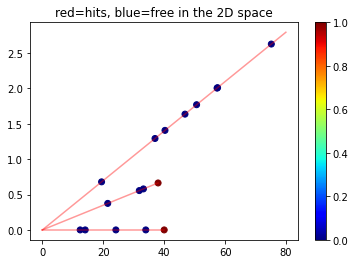

In [36]:
for i in range(len(th)):
  plt.plot(np.hstack((robot_pos[0], X[i,0])), np.hstack((robot_pos[1], X[i,1])), c='r', alpha=0.4)

plt.scatter(data_for_BHM[:,0], data_for_BHM[:,1], c=data_for_BHM[:,2], cmap='jet')
plt.colorbar()
plt.title('red=hits, blue=free in the 2D space');